In [1]:
import graphviz
import seaborn
%pylab inline
from sophscratch import *
seaborn.set_style("darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create a new graph


# Create variables
A = Variable([[1, 0], [0, -1]])
b = Variable([1, 1])

# Create placeholder
x = placeholder()

# Create hidden node y
y = matmul(A, x)

# Create output node z
z = add(y, b)

In [3]:
session = Session()
output = session.run(z, {
    x: [1, 2]
})
print(output)

[ 2 -1]


In [4]:
Graph().as_default()

x = placeholder()
w = Variable([1, 1])
b = Variable(0)
p = sigmoid( add(matmul(w, x), b) )

In [5]:
session = Session()
print(session.run(p, {
    x: [3, 2]
}))

0.993307149076


In [6]:
# Create a new graph
Graph().as_default()

X = placeholder()

# Create a weight matrix for 2 output classes:
# One with a weight vector (1, 1) for blue and one with a weight vector (-1, -1) for red
W = Variable([
    [1, -1],
    [1, -1]
])
b = Variable([0, 0])
p = softmax( add(matmul(X, W), b) )

# Create red points centered at (-2, -2)
red_points = np.random.randn(50, 2) - 2*np.ones((50, 2))

# Create blue points centered at (2, 2)
blue_points = np.random.randn(50, 2) + 2*np.ones((50, 2))

session = Session()
output_probabilities = session.run(p, {
    X: np.concatenate((blue_points, red_points))
})
print(output_probabilities[:10])

[[  9.99952960e-01   4.70401248e-05]
 [  9.99690609e-01   3.09391316e-04]
 [  9.93292525e-01   6.70747538e-03]
 [  9.99816374e-01   1.83625784e-04]
 [  9.97513543e-01   2.48645709e-03]
 [  9.98455012e-01   1.54498837e-03]
 [  9.99881412e-01   1.18588044e-04]
 [  9.99842666e-01   1.57333860e-04]
 [  9.98538919e-01   1.46108140e-03]
 [  9.99965672e-01   3.43279845e-05]]


In [7]:
X = placeholder()
c = placeholder()

W = Variable([
    [1, -1],
    [1, -1]
])
b = Variable([0, 0])
p = softmax( add(matmul(X, W), b) )

# Cross-entropy loss
J = negative(reduce_sum(reduce_sum(multiply(c, log(p)), axis=1)))

session = Session()
print(session.run(J, {
    X: np.concatenate((blue_points, red_points)),
    c:
        [[1, 0]] * len(blue_points)
        + [[0, 1]] * len(red_points)

}))

0.577763420066


In [8]:
# Create a new graph
Graph().as_default()

X = placeholder()
c = placeholder()

# Initialize weights randomly
W = Variable(np.random.randn(2, 2))
b = Variable(np.random.randn(2))

# Build perceptron
p = softmax( add(matmul(X, W), b) )

# Build cross-entropy loss
J = negative(reduce_sum(reduce_sum(multiply(c, log(p)), axis=1)))

# Build minimization op
minimization_op = GradientDescentOptimizer(loss=J, learning_rate = 0.01)

# Build placeholder inputs
feed_dict = {
    X: np.concatenate((blue_points, red_points)),
    c:
        [[1, 0]] * len(blue_points)
        + [[0, 1]] * len(red_points)

}

# Create session
session = Session()

# Perform 100 gradient descent steps
for step in range(100):
    J_value = session.run(J, feed_dict)
    if step % 10 == 0:
        print("Step:", step, " Loss:", J_value)
    session.run(minimization_op, feed_dict)

# Print final result
W_value = session.run(W)
print("Weight matrix:\n", W_value)
b_value = session.run(b)
print("Bias:\n", b_value)

Step: 0  Loss: 249.181624279
Step: 10  Loss: 0.310456982578
Step: 20  Loss: 0.270561125091
Step: 30  Loss: 0.24141956937
Step: 40  Loss: 0.219030332671
Step: 50  Loss: 0.20118526918
Step: 60  Loss: 0.186560086663
Step: 70  Loss: 0.174309065079
Step: 80  Loss: 0.16386492411
Step: 90  Loss: 0.154831833936
Weight matrix:
 [[ 0.97228839 -2.46704425]
 [ 1.09512979 -1.35359879]]
Bias:
 [ 0.22888725  1.16870176]


In [9]:
def lr_decay(e_o, e_t, t, k):
    if k >= t:
        return e_t
    alpha = k/t
    e_k = (1 - alpha)*e_o + alpha*e_t
    return e_k

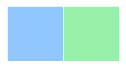

In [10]:
seaborn.palplot(seaborn.color_palette("pastel", 2))

In [11]:
def color_from_y(y):
    pal = seaborn.color_palette("pastel", 2)
    y_c = [pal[y_i[1]] for y_i in y]
    return y_c

In [62]:
def plot_softmax_boundary(x,y,p_output,n_grids=100,ax=None):
    # X - some data in 2dimensional np.array
    n_grids = 100
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    x_line, y_line = np.linspace(x_min, x_max, n_grids), np.linspace(y_min, y_max, n_grids)
    xx, yy = np.meshgrid(x_line,y_line)

    # # here "model" is your model's prediction (classification) function
    # Z = model(np.c_[xx.ravel(), yy.ravel()]) 

    Z = []
    for x_i in x_line:
        for y_i in y_line:
            pred_class = session.run(p_output,
                                  feed_dict={X: [[x_i, y_i]]})[0]
            Z.append( pred_class.argmax())

    # Put the result into a color plot
    Z = array(Z).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="Set3")

    y_c = [y_i[1] for y_i in y]
    # Plot also the training points
    ax.scatter(x[:, 0], x[:, 1], c=y_c, edgecolors='black', cmap="Set3")

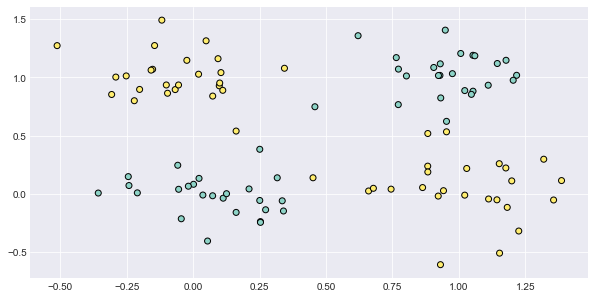

In [63]:
# Create two clusters of red points centered at (0, 0) and (1, 1), respectively.
red_points = np.concatenate((
    0.2*np.random.randn(25, 2) + np.array([[0, 0]]*25),
    0.2*np.random.randn(25, 2) + np.array([[1, 1]]*25)
))

# Create two clusters of blue points centered at (0, 1) and (1, 0), respectively.
blue_points = np.concatenate((
    0.2*np.random.randn(25, 2) + np.array([[0, 1]]*25),
    0.2*np.random.randn(25, 2) + np.array([[1, 0]]*25)
))
x = np.concatenate( (red_points,blue_points) ,axis=0)
y = array([[1, 0]] * len(blue_points) + [[0, 1]] * len(red_points))

# Plot them
y_c = [y_i[1] for y_i in y]
scatter(x[:, 0], x[:, 1], c=y_c, marker='o', edgecolors="black", cmap="Set3");

In [14]:
import random

hidden_size = 2



# Create a new graph
Graph().as_default()

# Create training input placeholder
X = placeholder()

# Create placeholder for the training classes
c = placeholder()

# Build a hidden layer
W_hidden = Variable(np.random.randn(2, hidden_size))
b_hidden = Variable(np.random.randn(hidden_size))
p_hidden = sigmoid( add(matmul(X, W_hidden), b_hidden) )

# Build the output layer
W_output = Variable(np.random.randn(hidden_size, 2))
b_output = Variable(np.random.randn(2))
p_output = softmax( add(matmul(p_hidden, W_output), b_output) )

# Build cross-entropy loss
J = negative(reduce_sum(reduce_sum(multiply(c, log(p_output) ), axis=1)))

# Build minimization op
minimization_op = GradientDescentOptimizer(loss=J, learning_rate=0.03)

# Build placeholder inputs
feed_dict = {
    X: np.concatenate((blue_points, red_points)),
    c:
        [[1, 0]] * len(blue_points)
        + [[0, 1]] * len(red_points)

}

# Create session
session = Session()

# Perform 100 gradient descent steps

epochs = 1000
mb_n = 10
history = {
    "loss":[]
}
max_iter = epochs*len(x)//mb_n
e_o = .01
e_t = .0001
t = max_iter*.8

for step in range(max_iter):
    
    mb_i = random.sample(range(len(x)),mb_n)
    feed_dict = {
        X: x[mb_i],
        c: y[mb_i]
    }
    
    lr = lr_decay(e_o,e_t,t,step)
    J_value = session.run(J, feed_dict)
    if step % (max_iter//10) == 0:
        print(f"Step: {step}, Loss: {J_value}, lr: {lr}")
       
    minimization_op.lr = lr
    grad = session.run(minimization_op, feed_dict)
    
    history["loss"].append(J_value)

# Print final result
W_hidden_value = session.run(W_hidden)
print("Hidden layer weight matrix:\n", W_hidden_value)
b_hidden_value = session.run(b_hidden)
print("Hidden layer bias:\n", b_hidden_value)
W_output_value = session.run(W_output)
print("Output layer weight matrix:\n", W_output_value)
b_output_value = session.run(b_output)
print("Output layer bias:\n", b_output_value)

Step: 0, Loss: 7.858929896052462, lr: 0.01
Step: 1000, Loss: 6.147926220146744, lr: 0.008762500000000001
Step: 2000, Loss: 5.131892380497028, lr: 0.007525
Step: 3000, Loss: 3.0313989559852477, lr: 0.0062875000000000006
Step: 4000, Loss: 2.505026278519628, lr: 0.00505
Step: 5000, Loss: 1.865179580198973, lr: 0.0038125
Step: 6000, Loss: 0.858419550324355, lr: 0.002575
Step: 7000, Loss: 2.095607718269328, lr: 0.0013375
Step: 8000, Loss: 1.5071412584598365, lr: 0.0001
Step: 9000, Loss: 0.6807633410260322, lr: 0.0001
Hidden layer weight matrix:
 [[ 5.27282276  4.32600841]
 [-5.53117856 -4.77112735]]
Hidden layer bias:
 [-2.8515187   2.39360443]
Output layer weight matrix:
 [[-5.12495313  4.45876473]
 [ 4.52436491 -4.39203629]]
Output layer bias:
 [-1.71518052  2.16057838]


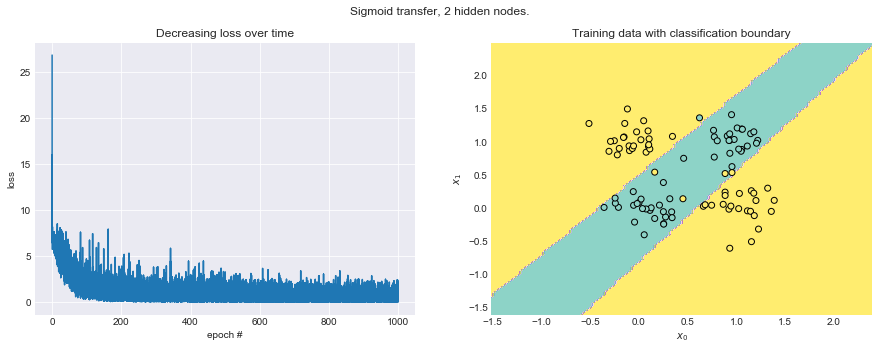

In [66]:
fig, axes = plt.subplots(1,2,squeeze=True,figsize=(15,5))
fig.suptitle(f"Sigmoid transfer, {hidden_size} hidden nodes.")

h_x = arange(len(history["loss"]))*mb_n//len(x)
axes[0].plot(h_x, history["loss"])
axes[0].set_xlabel("epoch #")
axes[0].set_ylabel("loss")
axes[0].set_title("Decreasing loss over time")
# axes[0].set_yscale("symlog")

plot_softmax_boundary(x,y,p_output,n_grids=100, ax=axes[1])
axes[1].set_xlabel("$x_0$")
axes[1].set_ylabel("$x_1$")
axes[1].set_title("Training data with classification boundary");

In [76]:
import random

hidden_size = 2

x = np.concatenate( (red_points,blue_points) ,axis=0)
y = array([[1, 0]] * len(blue_points) + [[0, 1]] * len(red_points))

# Create a new graph
Graph().as_default()

# Create training input placeholder
X = placeholder()

# Create placeholder for the training classes
c = placeholder()

# Build a hidden layer
W_hidden = Variable(np.random.randn(2, hidden_size))
b_hidden = Variable(np.random.randn(hidden_size))
p_hidden = relu( add(matmul(X, W_hidden), b_hidden) )

# Build the output layer
W_output = Variable(np.random.randn(hidden_size, 2))
b_output = Variable(np.random.randn(2))
p_output = softmax( add(matmul(p_hidden, W_output), b_output) )

# Build cross-entropy loss
J = negative(reduce_sum(reduce_sum(multiply(c, log(p_output)), axis=1)))

# Build minimization op
minimization_op = GradientDescentOptimizer(loss=J, learning_rate=0.03)

# Build placeholder inputs
feed_dict = {
    X: np.concatenate((blue_points, red_points)),
    c:
        [[1, 0]] * len(blue_points)
        + [[0, 1]] * len(red_points)

}

# Create session
session = Session()

# Perform 100 gradient descent steps

epochs = 1000
mb_n = 10
max_iter = epochs*len(x)//mb_n
e_o = .01
e_t = .00001
t = max_iter*.8

history = {
    "loss":[],
    "grad":[]
}

for step in range(max_iter):
    
    mb_i = random.sample(range(len(x)),mb_n)
    feed_dict = {
        X: x[mb_i],
        c: y[mb_i]
    }
    
    J_value = session.run(J, feed_dict)
    lr = lr_decay(e_o,e_t,t,step)
    if step % (max_iter//10) == 0:
        print(f"Step: {step}, Loss: {J_value}, lr: {lr}")
        
    history["loss"].append(J_value)
    minimization_op.lr = lr
    session.run(minimization_op, feed_dict)

# Print final result
W_hidden_value = session.run(W_hidden)
print("Hidden layer weight matrix:\n", W_hidden_value)
b_hidden_value = session.run(b_hidden)
print("Hidden layer bias:\n", b_hidden_value)
W_output_value = session.run(W_output)
print("Output layer weight matrix:\n", W_output_value)
b_output_value = session.run(b_output)
print("Output layer bias:\n", b_output_value)

Step: 0, Loss: 42.918269932985524, lr: 0.01
Step: 1000, Loss: 4.451929024308607, lr: 0.00875125
Step: 2000, Loss: 0.9973766818179111, lr: 0.0075025
Step: 3000, Loss: 0.24386725615068644, lr: 0.006253750000000001
Step: 4000, Loss: 2.1407284973312164, lr: 0.005005
Step: 5000, Loss: 1.2706221776553865, lr: 0.00375625
Step: 6000, Loss: 0.9112347024164253, lr: 0.0025075
Step: 7000, Loss: 4.840896272517321, lr: 0.00125875
Step: 8000, Loss: 0.4042306201702843, lr: 1e-05
Step: 9000, Loss: 4.571066392975264, lr: 1e-05
Hidden layer weight matrix:
 [[ -4.91327017  11.97900872]
 [ -4.37404146  13.30198125]]
Hidden layer bias:
 [ 4.49889592 -8.1982472 ]
Output layer weight matrix:
 [[ 3.00585275 -0.84699394]
 [ 0.58896244 -0.24113291]]
Output layer bias:
 [-5.13201652  4.43310347]


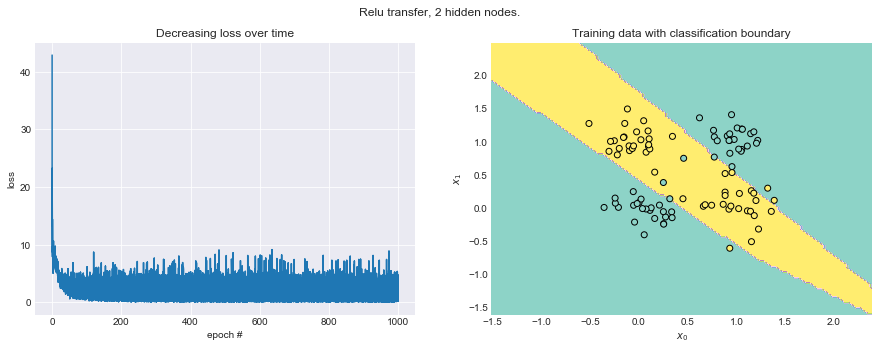

In [77]:
fig, axes = plt.subplots(1,2,squeeze=True,figsize=(15,5))
fig.suptitle(f"Relu transfer, {hidden_size} hidden nodes.")

h_x = arange(len(history["loss"]))*mb_n//len(x)
axes[0].plot(h_x, history["loss"])
axes[0].set_xlabel("epoch #")
axes[0].set_ylabel("loss")
axes[0].set_title("Decreasing loss over time")
# axes[0].set_yscale("symlog")

plot_softmax_boundary(x,y,p_output,n_grids=100, ax=axes[1])
axes[1].set_xlabel("$x_0$")
axes[1].set_ylabel("$x_1$")
axes[1].set_title("Training data with classification boundary");